# Seasonality of the Mixed Layer Depth (MLD) Group
OOI Data Labs Workshop - August 2019

Revised Jan 22, 2020

**Working Title**: Seasonal Variability In The Mixed Layer 

**Short Description**: How and why does the mixed layer depth in the ocean vary

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import dask
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Setup default plot styles
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

## Request Data from OOINet (run only once)

This activity was initially inspired by the June Thermohaline activity.  Thus it will also use at least 1 year from [Irminger Sea Flanking Mooring B](https://datareview.marine.rutgers.edu/sites/view/GI03FLMB), and will include the following variables:
* Solar irradiance (downwelling short-wave) 
* Wind speed - Because the METBK data is gappy, we need to use surface wind speed data from ECMWF reanalysis from a co-located gridpoint.
* CTD Temperature - Temperature data will be presented as a multi-year time series, as well as a profile plot for a selected time.
  * 0m - GI01SUMO-SBD12-06-METBKA000 - From the nearby surface buoy. Probably too gappy to use.
  * 30m - GI03FLMB-RIM01-02-CTDMOG060
  * 40m - GI03FLMB-RIM01-02-CTDMOG061
  * 60m - GI03FLMB-RIM01-02-CTDMOG062
  * 90m - GI03FLMB-RIM01-02-CTDMOG063
  * 130m - GI03FLMB-RIM01-02-CTDMOG064
  * 180m - GI03FLMB-RIM01-02-CTDMOG065
  * 250m - GI03FLMB-RIM01-02-CTDMOG066
  * 350m - GI03FLMB-RIM01-02-CTDMOG067
  * 500m - GI03FLMB-RIM01-02-CTDMOG068
  * 750m - GI03FLMB-RIM01-02-CTDMOG069
  * 1000m - GI03FLMB-RIM01-02-CTDMOH070
  * 1500m - GI03FLMB-RIM01-02-CTDMOG071 - Not recommended, will extend the graph by 50% for one datapoint
* Chlorophyll - GI03FLMB-RIS01-05-FLORTD000 (Application only) - This is from 30m.  The Surface Buoy also has 1m and 12m FLORTs available.

For the Concept Invention variant, the group would like the same mix as above but for Station Papa.

In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# Data Requests
# request_data('GI01SUMO-SBD12-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered')
# request_data('GI03FLMB-RIS01-05-FLORTD000','recovered_host','flort_sample')

ctds = ['GI03FLMB-RIM01-02-CTDMOG060',
 'GI03FLMB-RIM01-02-CTDMOG061',
 'GI03FLMB-RIM01-02-CTDMOG062',
 'GI03FLMB-RIM01-02-CTDMOG063',
 'GI03FLMB-RIM01-02-CTDMOG064',
 'GI03FLMB-RIM01-02-CTDMOG065',
 'GI03FLMB-RIM01-02-CTDMOG066',
 'GI03FLMB-RIM01-02-CTDMOG067',
 'GI03FLMB-RIM01-02-CTDMOG068',
 'GI03FLMB-RIM01-02-CTDMOH069',
 'GI03FLMB-RIM01-02-CTDMOH070']

# for ctd in ctds:
#   print(ctd)
#   response = request_data(ctd,'recovered_inst','ctdmo_ghqr_instrument_recovered')
#   print(response)


## Helper Functions

In [0]:
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  selected_datasets = sorted(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  ds = ds.chunk({'time': 1000}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

## 2. Load Data Files

In [0]:
url_met = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175106220Z-GI01SUMO-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
url_flort = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175116162Z-GI03FLMB-RIS01-05-FLORTD000-recovered_host-flort_sample/catalog.html'
url_ctd={}
url_ctd['30m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175239257Z-GI03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd['40m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175239672Z-GI03FLMB-RIM01-02-CTDMOG061-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd['60m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175239950Z-GI03FLMB-RIM01-02-CTDMOG062-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd['90m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175240318Z-GI03FLMB-RIM01-02-CTDMOG063-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd['130m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175240608Z-GI03FLMB-RIM01-02-CTDMOG064-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd['180m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175241289Z-GI03FLMB-RIM01-02-CTDMOG065-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd['250m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175242149Z-GI03FLMB-RIM01-02-CTDMOG066-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd['350m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175243013Z-GI03FLMB-RIM01-02-CTDMOG067-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd['500m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175243747Z-GI03FLMB-RIM01-02-CTDMOG068-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd['750m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175740568Z-GI03FLMB-RIM01-02-CTDMOH069-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd['1000m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175716474Z-GI03FLMB-RIM01-02-CTDMOH070-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'


Loading: 30m
Loading: 40m
Loading: 60m
Loading: 90m
Loading: 130m
Loading: 180m
Loading: 250m
Loading: 350m
Loading: 500m
Loading: 750m
Loading: 1000m


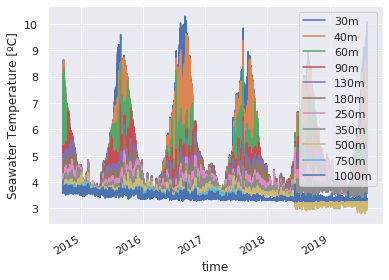

In [8]:
# Load all Temperature datasets - Daily averaged
ctd_temp = xr.Dataset()
for ctd in url_ctd.keys():
  # Load Data
  print('Loading: %s' % ctd)
  data = get_data(url_ctd[ctd])
  # Remove Outliers
  data['ctdmo_seawater_temperature'] = data['ctdmo_seawater_temperature'].where(reject_outliers(data['ctdmo_seawater_temperature']))
  d = data['ctdmo_seawater_temperature'].load().resample(time='1D').mean()
  d = d.to_dataset().rename({'ctdmo_seawater_temperature': ctd})
  ctd_temp = xr.merge([ctd_temp, d])
  # Plot
  data.ctdmo_seawater_temperature.plot(label=ctd)

plt.legend();

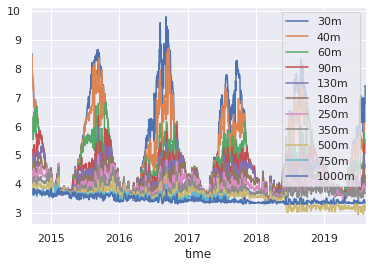

In [9]:
# Plot of daily average
ctd_temp.to_dataframe().plot();

In [0]:
# Load other datasets
data_met = get_data(url_met,'velpt')
data_chl = get_data(url_flort,'ctdmo')

In [0]:
# Filter and average other datasets
data_met['shortwave_irradiance'] = data_met['shortwave_irradiance'].where(reject_outliers(data_met['shortwave_irradiance']))

d1 = data_met.met_relwind_speed.load().resample(time='1D').mean()
d2 = data_met.shortwave_irradiance.load().resample(time='1D').mean()
d3 = data_chl.fluorometric_chlorophyll_a.load().resample(time='1D').mean()

alldata = xr.merge([ctd_temp,d1,d2,d3])

## Model Data for the Surface
Because the surface mooring is so gappy, we will grab wind and irradiance data from ERA5.  See appendix for more.

In [12]:
# Open dataset
era5 = xr.open_dataset('era5data.nc')
era5

<xarray.Dataset>
Dimensions:    (latitude: 9, longitude: 9, time: 17528)
Coordinates:
  * longitude  (longitude) float32 -40.0 -39.75 -39.5 ... -38.5 -38.25 -38.0
  * latitude   (latitude) float32 61.0 60.75 60.5 60.25 ... 59.5 59.25 59.0
  * time       (time) datetime64[ns] 2014-01-01 ... 2019-12-31T21:00:00
Data variables:
    u10_0001   (time, latitude, longitude) float32 ...
    v10_0001   (time, latitude, longitude) float32 ...
    t2m_0001   (time, latitude, longitude) float32 ...
    sst_0001   (time, latitude, longitude) float32 ...
    ssrd_0001  (time, latitude, longitude) float32 ...
    u10_0005   (time, latitude, longitude) float32 ...
    v10_0005   (time, latitude, longitude) float32 ...
    t2m_0005   (time, latitude, longitude) float32 ...
    sst_0005   (time, latitude, longitude) float32 ...
    ssrd_0005  (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-17 22:50:21 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [0]:
# Combine historical and recent variables
era5['u10'] = era5.u10_0001.combine_first(era5.u10_0005)
era5['v10'] = era5.v10_0001.combine_first(era5.v10_0005)
era5['sst'] = era5.sst_0001.combine_first(era5.sst_0005)
era5['ssrd'] = era5.ssrd_0001.combine_first(era5.ssrd_0005)

# Calculate Wind Speed
era5['ws'] = (era5.u10**2 + era5.v10**2)**.5

# Convert J/m^2 to W/m^2 for Irradiance
era5['irr'] = era5['ssrd']/3600

# Average grid points
era5['ws_avg'] = era5['ws'].mean(dim=['longitude','latitude'])
era5['sst_avg'] = era5['sst'].mean(dim=['longitude','latitude'])
era5['irr_avg'] = era5['irr'].mean(dim=['longitude','latitude'])

# Daily Means
era5b = era5[['ws_avg','sst_avg','irr_avg']].resample(time='1D').mean()

# Add to full dataset
alldata2 = xr.merge([ctd_temp,d1,d2,d3,era5b])

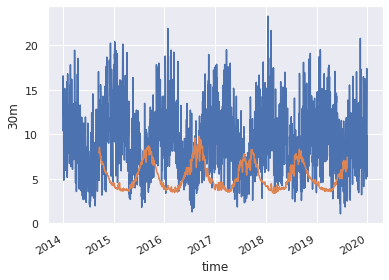

In [14]:
alldata2.ws_avg.plot()
alldata2['30m'].plot()

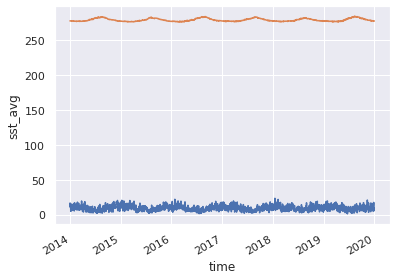

In [16]:
alldata2.ws_avg.plot()
alldata2['sst_avg'].plot()

In [0]:
# 1 Week Average
alldata2_1w = alldata2.resample(time='1W').mean().to_dataframe()

## Plot the Data

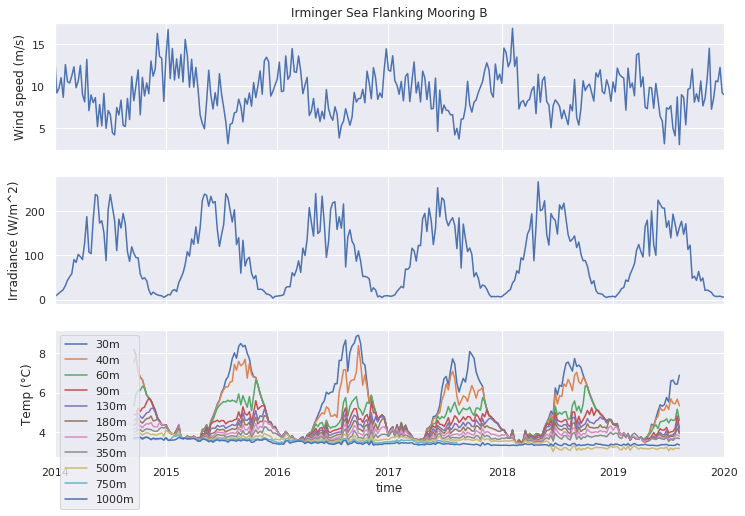

In [30]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(12,8))

# Winds
alldata2_1w.ws_avg.plot(ax=ax1)
ax1.set_ylabel('Wind speed (m/s)')

# Irradiance
alldata2_1w.irr_avg.plot(ax=ax2)
ax2.set_ylabel('Irradiance (W/m^2)')

# Temperature
alldata2_1w['30m'].plot(ax=ax3,label='30m')
alldata2_1w['40m'].plot(ax=ax3,label='40m')
alldata2_1w['60m'].plot(ax=ax3,label='60m')
alldata2_1w['90m'].plot(ax=ax3,label='90m')
alldata2_1w['130m'].plot(ax=ax3,label='130m')
alldata2_1w['180m'].plot(ax=ax3,label='180m')
alldata2_1w['250m'].plot(ax=ax3,label='250m')
alldata2_1w['350m'].plot(ax=ax3,label='350m')
alldata2_1w['500m'].plot(ax=ax3,label='500m')
alldata2_1w['750m'].plot(ax=ax3,label='750m')
alldata2_1w['1000m'].plot(ax=ax3,label='1000m')
#ax3.set_ylim(1026.75, 1028)
#ax3.set_xlim(weekly_30m.time.values.min(), weekly_30m.time.values.max())
ax3.legend()
ax3.set_ylabel('Temp (°C)')

ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.set_title('Irminger Sea Flanking Mooring B');

plt.savefig('Irminger_MLD.png');

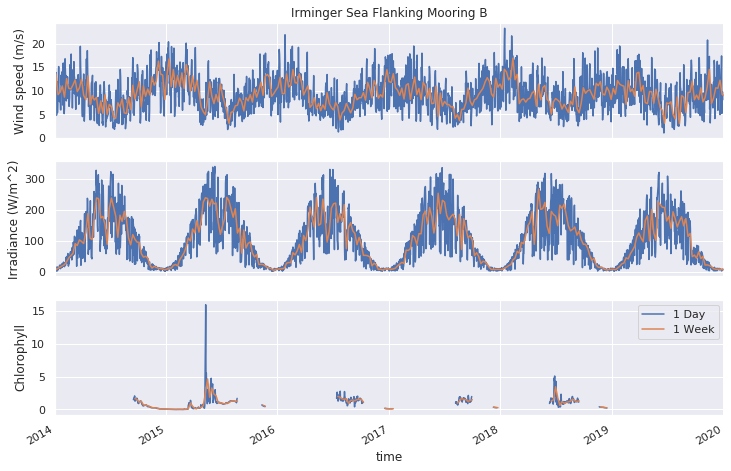

In [33]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(12,8))

# Winds
alldata2.ws_avg.plot(ax=ax1)
alldata2_1w.ws_avg.plot(ax=ax1)
ax1.set_ylabel('Wind speed (m/s)')

# Irradiance
alldata2.irr_avg.plot(ax=ax2)
alldata2_1w.irr_avg.plot(ax=ax2)
ax2.set_ylabel('Irradiance (W/m^2)')

# Chlorophyll
alldata2.fluorometric_chlorophyll_a.plot(ax=ax3,label='1 Day')
alldata2_1w.fluorometric_chlorophyll_a.plot(ax=ax3,label='1 Week')
ax3.legend()
ax3.set_ylabel('Chlorophyll')

ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.set_title('Irminger Sea Flanking Mooring B');

plt.savefig('Irminger_Chl.png');

In [0]:
# Export to CSV
alldata2_1w.to_csv('mld.csv')

## Appendix - Requesting Model Data
Data from ECMWF can be obtained using the following script.  Previoulsy we used ERA-Interium, but that was discontinued in Aug 2019, so now we need to use ERA5.  For more, see the [ERA5 CDS API Doc](https://confluence.ecmwf.int/display/CKB/How+to+download+ERA5)

Note, in order for this to run on Colab, you will need to create a file at /root/.cdsapirc with your [api key](https://cds.climate.copernicus.eu/api-how-to).

In [0]:
# # First upload the file to your Colab workspace, then move it with this command
# ! mv /content/cdsapirc /root/.cdsapirc

In [0]:
# pip install cdsapi

In [0]:
# # Request ERA5 data for Irminger Sea area
# import cdsapi
# c = cdsapi.Client()
# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'variable': [
#             '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature',
#             'sea_surface_temperature', 'surface_solar_radiation_downwards',
#         ],
#         'year': [
#             '2014','2015', '2016', 
#             '2017','2018', '2019',
#         ],
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '03:00', '06:00',
#             '09:00', '12:00', '15:00',
#             '18:00', '21:00',
#         ],
#         'area' : [61, -40, 59, -38], # North, West, South, East.
#         'format': 'netcdf',
#     },
#     'era5data.nc')

In [0]:
# # Download datafile
# url_ecm = 'http://136.156.133.32/cache-compute-0009/cache/data7/adaptor.mars.internal-1579212914.3257482-24922-17-626b9dcc-598c-4be3-a5d0-0330354461ae.nc'
# from urllib.request import urlretrieve
# urlretrieve(url_ecm,'ecmdata.nc')

## Questions
* How much data do you need?  Just 1 year, or ~5 years?
* Is weekly averaging okay?  If we're going with a longer term dataset, than I'm assuming so.
* For the CI activity... did you really need a fully matched dataset for Station Papa, i.e. surface winds, irradiance, and all 10 levels of CTDs?  Or is a smaller set okay (e.g. 4 CTDs)?
* Do you need any other data in the final file (e.g. salinity, density, potential density)?
* Do you really need 0m temperatures?  Since that's from the surface mooring, it's very gappy.  We could use model data, but not sure it would match well.
* Do you really need 1,500m temperatures?  It adds 50% more vertical space to the graph, without adding much.
* Instead of buoy irradiance, I'm using `Surface solar radiation downwards`. Is that the best one to use? [ERA5 variable list](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)